In [2]:
import nltk, nltk.classify.util, nltk.metrics
from sklearn.linear_model import LogisticRegression
from nltk.classify import SklearnClassifier


In [3]:
import pickle
import numpy as np

In [4]:
# with open('mnist_temp_act_full1.pkl','rb') as f:
with open('mnist_padded_act_full1.pkl','rb') as f:
    action_records1,labels1 = pickle.load(f)
# with open('mnist_temp_act_full2.pkl','rb') as f:
with open('mnist_padded_act_full2.pkl','rb') as f:
    action_records2,labels2 = pickle.load(f)
action_records   = action_records1 + action_records2

#mnist_boltz1_act_full1  - gamma=0.99 - beta=0.1 speed penalty =0
#mnist_boltz2_act_full1  - gamma=0.99 - beta=1.0 speed penalty =0
#mnist_boltz3_act_full1  - gamma=0.99 - beta=1.0 speed penalty =5 
#mnist_boltz4_act_full1 - gamma=0.99 - beta=0.03 speed penalty =5
#mnist_boltz5_act_full1 - gamma=0.99 - beta=1(orig 0.03) speed penalty =5
#6B -  big actions with penalty 200, gamma=0.99 - beta=1.0 (orig 0.03) speed penalty =0

from mnist import MNIST

mnist = MNIST('/home/bnapp/datasets/mnist/')

_, labels = mnist.load_training()



In [5]:
images, labels = mnist.load_training()


In [6]:
len(action_records)

59904

In [7]:
def prep_n_grams(x,n=None,offsets=None):
    if (n is None) and  not (offsets is None):
        pass
    elif not(n is None) and (offsets is None):
        offsets = list(range(n))
    else:
        error('need to provide either n or offsets')
    ngram_dict = {}
    for ii in range(len(x)-offsets[-1]):
        this_ngram = tuple(x[ii+oo] for oo in offsets)
        if this_ngram in ngram_dict.keys():
            ngram_dict[this_ngram] +=1
        else:
            ngram_dict[this_ngram] = 1
    return ngram_dict

ngram_records=[prep_n_grams(aa,offsets=[0,3,6,9,12]) for aa in action_records]

train_data=[(x,y) for x,y in zip(ngram_records[:3500],labels[:3500])]

classifier = SklearnClassifier(SVC(), sparse=False).train(train_data)

    val_labels=classifier.classify_many(ngram_records[3500:])
    aa=[x==y for x,y in zip(val_labels,labels[3500:])]
    print(np.mean(aa))

In [8]:
# ngram4_records=[prep_n_grams(aa,offsets=[0,2,4,6,8]) for aa in action_records]
classifiers=[]
accu=[]
for lagfac in [1.5]: #[1.0,1.2,1.4,1.6,1.8]:
    offsets=[np.int32(np.round(uu)) for uu in
             [0*lagfac,1*lagfac,2*lagfac,3*lagfac,4*lagfac,5*lagfac,6*lagfac]
            ]
    ngram_records=[prep_n_grams(aa[:1000],offsets=offsets) for aa in action_records]
    #ngram4_records=[prep_n_grams(aa,offsets=[0,2,4,6]) for aa in action_records]
#     print('ngrams:',len(ngram_records))
    train_max=55000

    train_data4=[(x,y) for x,y in zip(ngram_records[:train_max],labels[:train_max])]

    # classifier4 = SklearnClassifier(LogisticRegression(C=1e6,solver='sag',max_iter=100), sparse=False).train(train_data4)
    # classifier4 = SklearnClassifier(LogisticRegression(), sparse=False).train(train_data4)
    classifier4 = SklearnClassifier(LogisticRegression(C=0.02), sparse=False).train(train_data4)

    val_labels4=classifier4.classify_many(ngram_records[train_max:])
    aa=[x==y for x,y in zip(val_labels4,labels[train_max:])]
    print(np.mean(aa))
    accu.append(np.mean(aa))

    train_labels4=classifier4.classify_many(ngram_records[:train_max])
    aatr=[x==y for x,y in zip(train_labels4,labels[:train_max])]
    print(np.mean(aatr))
    classifiers.append(classifier4)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8185154975530179
0.8596181818181818


In [ ]:
Baseline (4 grams, lag (e.g.stride) 1):
0.708605220228385
0.6888545454545455
-------3 grams:
0.5970636215334421
0.5792727272727273
-------5 grams (!!!! due to mistake, unigrams involved are: 0,1,2,4,5, skipping 3)
0.7734502446982056
0.7774
      same but  ------lag 2: 
        0.7336867862969005
        0.7429272727272728...  etc..
-------ordinary 5 grams:
0.757137030995106
0.7639454545454546
-------
0.7134991843393148
0.7192
------- 6 grams (strides 1,2,3):
stride 1
0.7901712887438825
0.8326727272727272

stride 2

0.7408238172920065
0.7967090909090909

stride 3

0.700652528548124
0.7659090909090909
---------- 7-gram
stride 1
0.7856851549755302
0.9108909090909091
stride 2
0.7512234910277324
0.8895090909090909
stride 3
0.6988172920065253
0.8652363636363636
-----stride 1
C=1
0.7856851549755302
0.9108909090909091

C=0.5
0.793026101141925
0.9004909090909091

C=0.1
0.8062805872756933
0.8730363636363636

C=0.05
0.8083197389885808
0.8602

C=0.01
0.810562805872757
0.8281818181818181

C=0.001
0.7979200652528549
0.7789454545454545
---- stride (a.k.a. lag) 1


C=1.0, L1
0.7934339314845025
0.8934727272727273

C=0.5, L1
0.8028140293637847
0.8701090909090909

C=0.1, L1
0.808115823817292
0.8160909090909091

C=0.05, L1
0.7985318107667211
0.7938545454545455
************************************* detailed study: C=0.1, L1
total features: 12444
    
wights greater than: 1e-05 ignored_features [frac]: 0.7892960462873674     validation accuracy: 0.808115823817292
wights greater than: 0.0001 ignored_features [frac]: 0.7892960462873674     validation accuracy: 0.808115823817292
wights greater than: 0.001 ignored_features [frac]: 0.7894567663130826     validation accuracy: 0.8087275693311582
wights greater than: 0.003 ignored_features [frac]: 0.7899389263902282     validation accuracy: 0.8091353996737357
wights greater than: 0.01 ignored_features [frac]: 0.7934747669559628     validation accuracy: 0.7277732463295269
wights greater than: 0.03 ignored_features [frac]: 0.8014304082288654     validation accuracy: 0.6829119086460033
wights greater than: 0.1 ignored_features [frac]: 0.8480392156862745     validation accuracy: 0.5375203915171288
wights greater than: 0.2 ignored_features [frac]: 0.9206846673095468     validation accuracy: 0.5234502446982056
wights greater than: 0.3 ignored_features [frac]: 0.9657666345226615     validation accuracy: 0.3550163132137031
wights greater than: 0.4 ignored_features [frac]: 0.9856155576984892     validation accuracy: 0.24469820554649266
wights greater than: 0.5 ignored_features [frac]: 0.994133719061395     validation accuracy: 0.16619086460032625
---
wights less than: 0.03 ignored_features [frac]: 0.9101575056252009     validation accuracy: 0.1449836867862969
wights less than: 0.1 ignored_features [frac]: 0.8351816136290582     validation accuracy: 0.29995921696574224
wights less than: 0.2 ignored_features [frac]: 0.8056091288974606     validation accuracy: 0.5560766721044046
wights less than: 0.3 ignored_features [frac]: 0.7959659273545484     validation accuracy: 0.782626427406199
wights less than: 0.4 ignored_features [frac]: 0.7925908068145291     validation accuracy: 0.8013866231647635
wights less than: 0.5 ignored_features [frac]: 0.7905818064930891     validation accuracy: 0.8068923327895595
wights less than: 0.6 ignored_features [frac]: 0.7896174863387978     validation accuracy: 0.8075040783034257
wights less than: 0.7 ignored_features [frac]: 0.789376406300225     validation accuracy: 0.8085236541598695

**************************************
C=0.02
STRIDE 1.0
0.8107667210440457
0.8422909090909091

STRIDE 1.2
0.8060766721044046
0.8551818181818182

STRIDE 1.4
0.8148450244698205
0.8556

STRIDE 1.6
0.8107667210440457
0.8529636363636364

STRIDE 1.8
0.802610114192496
0.8482727272727273

C=0.005
stride=1.4
0.8103588907014682
0.8223454545454545

stride=1.5
0.8152528548123981
0.8263454545454545

stride=1.6
0.8050570962479608
0.8209454545454545
------------------------8 grams C=0.02
done with ngrams [0, 1, 2, 3, 4, 5, 6, 7]
0.8211663947797716
0.8751454545454546
done with ngrams [0, 1, 2, 4, 5, 6, 7, 8]
0.8262642740619902
0.8885818181818181
done with ngrams [0, 1, 3, 4, 6, 7, 8, 10]
0.8295269168026101
0.896090909090909
done with ngrams [0, 2, 3, 5, 6, 8, 10, 11]
0.825652528548124
0.8943454545454546
done with ngrams [0, 2, 4, 5, 7, 9, 11, 13]
0.8207585644371941
0.8883272727272727

----9-gram, C=0.2, L1 regularization
with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12], feature freq>100
0.8354404567699837
0.9044909090909091
for C in [0.15, 0.1, 0.08, 0.06]:
C= 0.15
0.8342169657422512
0.8867454545454545
C= 0.1
0.8301386623164764
0.862909090909091
C= 0.08
0.8289151712887439
0.8508363636363636
C= 0.06
0.8268760195758564
0.8359636363636364

----10-gram, C=0.2, L1 regularization
with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12, 14], feature freq>100
0.8303425774877651
0.9201818181818182
-----9-grams, L1, freq>1000
features: ~3900
    classifiers_temp_n9_l1_sweep_th1000_pp.pkl
    done with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12]
done truncation
C= 1
0.8038336052202284
0.9250181818181819
C= 0.8
0.808931484502447
0.9210909090909091
C= 0.6
0.8128058727569332
0.9150181818181818
C= 0.4
0.8189233278955954
0.9051636363636364
C= 0.2
0.8311582381729201
0.8829272727272728
------
same but f>10000:
classifiers_temp_n9_l1_sweep_th10000_pp.pkl
done with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12]
done truncation
C= 10
0.7879282218597063
0.7886909090909091
C= 5
0.7879282218597063
0.7886909090909091
C= 2
0.7883360522022839
0.7886909090909091
------------------------
V penalty = 20.
f>1000;
classifiers_temp_v20_n9_l1_sweep_th1000_pp.pkl
done with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12]
done truncation
C= 1
0.6704730831973899
0.9999818181818182
C= 0.8
0.674347471451876
0.9997818181818182
C= 0.6
0.6867862969004894
0.9985272727272727
C= 0.4
0.6943311582381729
0.9892
C= 0.2
0.717373572593801
0.9457636363636364
--                                                                                                          ^
and: classifiers_temp_v20_n9_l1_sweep_th1000_pp2.pkl
done with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12]
done truncation
C= 0.1
0.7259380097879282
0.8726363636363637
C= 0.08
0.7255301794453507
0.8444
C= 0.06
0.7228792822185971
0.8075454545454546
C= 0.04
0.7010603588907015
0.7524545454545455
C= 0.02
0.6525285481239804
0.6584545454545454
------------------

V_penalty=0:

0.6704730831973899
0.9977818181818182
C= 0.8
0.6794453507340946
0.9945636363636363
C= 0.6
0.6908646003262643
0.9862
C= 0.4
0.7055464926590538
0.9668909090909091
C= 0.2
0.7298123980424144
0.9164
C= 0.1
0.7424551386623165
0.8527090909090909
C= 0.08
0.7400081566068516
0.8300727272727273
C= 0.06
0.7393964110929854
0.8017272727272727
C= 0.04
0.7304241435562806
0.7614545454545455
C= 0.02
0.7073817292006526
0.6973818181818182
order of files:
with open('classifiers_temp_v0_n9_l1_sweep_th1000_pp2.pkl','wb') as f:
with open('classifiers_temp_v0_n9_l1_sweep_th1000_pp.pkl','wb') as f:
_____________________________
default net but beta=1 at inference:
done with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12]
done truncation
C= 1
0.6712887438825449
0.7704363636363636
C= 0.8
0.6763866231647635
0.7684727272727273
C= 0.6
0.6786296900489397
0.7651454545454546
C= 0.4
0.6806688417618271
0.7597454545454545
C= 0.2
0.6798531810766721
0.7448727272727272
C= 0.1
0.6802610114192496
0.7233636363636363
C= 0.08
0.6800570962479608
0.7152909090909091
C= 0.06
0.6774061990212071
0.7048181818181818
C= 0.04
0.6745513866231647
0.6888545454545455
C= 0.02
0.6633360522022839
0.6583818181818182

------------------------
beta=0.03:
    loading from:  mnist_padded_b0p03_act_full1.pkl and mnist_padded_b0p03_act_full2.pkl
    done with ngrams [0, 2, 3, 4, 6, 8, 9, 10, 12]
done truncation
C= 1
0.6763866231647635
0.9139636363636363
C= 0.8
0.6849510603588908
0.9086909090909091
C= 0.6
0.697389885807504
0.9012181818181818
C= 0.4
0.7118678629690048
0.8881454545454546
C= 0.2
0.7275693311582382
0.8573272727272727
C= 0.1
0.7375611745513866
0.8149454545454545
C= 0.08
0.7396003262642741
0.8002545454545454
C= 0.06
0.7359298531810766
0.7798909090909091
C= 0.04
0.7298123980424144
0.7523454545454545
C= 0.02
0.7100326264274062
0.708709090909091


In [ ]:
len(ngram_records[0])

In [ ]:
classifiers

In [ ]:
accu

In [ ]:
lagfac=1

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


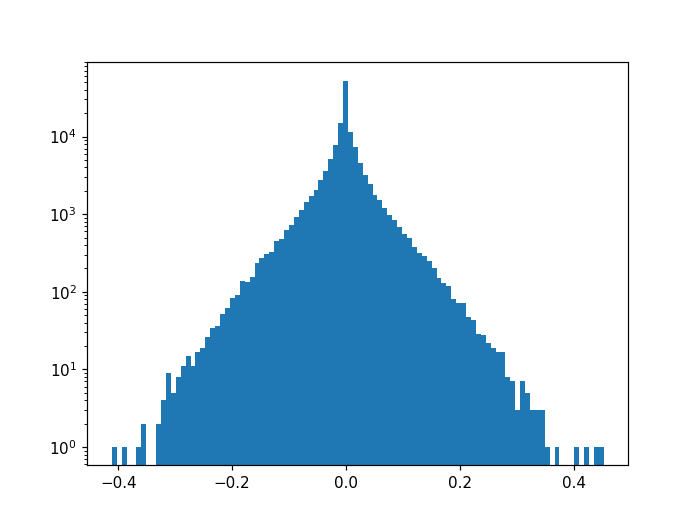

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        4.0000e+00, 9.0000e+00, 5.0000e+00, 8.0000e+00, 1.1000e+01,
        1.5000e+01, 1.1000e+01, 1.7000e+01, 1.9000e+01, 2.6000e+01,
        3.4000e+01, 3.6000e+01, 5.2000e+01, 6.1000e+01, 8.4000e+01,
        9.1000e+01, 1.3700e+02, 1.3400e+02, 1.5600e+02, 2.3400e+02,
        2.7000e+02, 3.0700e+02, 3.2800e+02, 4.4500e+02, 4.7900e+02,
        6.2700e+02, 7.3300e+02, 9.2300e+02, 1.1180e+03, 1.4220e+03,
        1.7070e+03, 2.0370e+03, 2.7490e+03, 3.6200e+03, 5.1180e+03,
        7.8440e+03, 1.4775e+04, 5.2614e+04, 1.1595e+04, 7.3310e+03,
        4.5240e+03, 3.1900e+03, 2.4370e+03, 1.7890e+03, 1.5120e+03,
        1.2100e+03, 9.6200e+02, 8.3400e+02, 6.9100e+02, 5.4900e+02,
        5.0000e+02, 3.7500e+02, 3.1200e+02, 2.9100e+02, 2.5100e+02,
        2.0100e+02, 1.5000e+02, 1.3000e+02, 1.1800e+02, 8.1000e+01,
        7.1000e+01, 7.1000e+01, 4.8000e+01, 4.30

In [10]:
plt.figure()
plt.hist(classifiers[0]._clf.coef_.reshape([-1]),bins=100,log=True)